<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#처리-단계-명세" data-toc-modified-id="처리-단계-명세-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>처리 단계 명세</a></span></li><li><span><a href="#검색어-입력" data-toc-modified-id="검색어-입력-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>검색어 입력</a></span></li><li><span><a href="#데이터-불러오기" data-toc-modified-id="데이터-불러오기-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>데이터 불러오기</a></span></li><li><span><a href="#전처리" data-toc-modified-id="전처리-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>전처리</a></span></li><li><span><a href="#문서별-카테고리-할당" data-toc-modified-id="문서별-카테고리-할당-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>문서별 카테고리 할당</a></span></li><li><span><a href="#카테고리-별-토픽-할당" data-toc-modified-id="카테고리-별-토픽-할당-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>카테고리 별 토픽 할당</a></span></li><li><span><a href="#토픽-별-대표기사-추출" data-toc-modified-id="토픽-별-대표기사-추출-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>토픽 별 대표기사 추출</a></span></li><li><span><a href="#카테고리---토픽-/-시간에-따른-뉴스-빈도" data-toc-modified-id="카테고리---토픽-/-시간에-따른-뉴스-빈도-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>카테고리 - 토픽 / 시간에 따른 뉴스 빈도</a></span></li><li><span><a href="#단계별-처리-시간-시각화" data-toc-modified-id="단계별-처리-시간-시각화-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>단계별 처리 시간 시각화</a></span></li></ul></div>

In [0]:
import modules.newsight as ns 

# 시각화
import matplotlib.pyplot as plt
import seaborn as sb

# file I/O
import pickle
import pandas as pd

import re # 정규표현식
import numpy as np # 연산
import time # 연산 시간 측정
time_list = [] # 각 단계별 처리 시간 저장
process = ['load_data' ,' preprocess - get proper docs A','preprocess - get proper doc B', 'get category', 'get topic - vectorize',
'get topic-DBSCAN','get main doc']

# 경고 메시지 숨기기
import warnings
warnings.filterwarnings("ignore")

## 처리 단계 명세

**DB** workflow v3 전처리(토큰화).ipynb 

1. **검색어 입력**
2. **데이터 불러오기**(raw data)   
1. **전처리**  
    1.1. 특수문자, 일반적 불용어 제거  
    1.2. 유효 명사 추가     
    1.4. 검색어에 대한 불용어 제거  
    1.3. 명사 추출  

**Backend** <font color='red'>workflow v3 유효기사추출 - 대표기사추출.ipynb </font> 

1. **검색어 입력**
2. **데이터 불러오기**(tokenized data)
3. **유효문서 추출**  
    3.2. 유효 문서 추출 A (제목에 검색어를 포함하는 문서만 추출, 제목에 [ ]가 들어간 문서 제외)  
    3.3. 유효 문서 추출 B (본문에 검색어가 3번 이상 들어가는 문서만 추출) 
4. **문서별 카테고리 할당**
5. **카테고리 별 토픽 할당**  
    5.1. 벡터화 (TFIDF)  
    5.2. 군집화 (DBSCAN)
6. **토픽 별 대표기사 추출**
    6.1. 토픽별 문서 벡터화 (TFIDF)  
    6.2. 토픽별 대표 키워드 추출 (SVD)  
    6.3. 토픽별 대표 문서 추출 (BM25)  
    
**Frontend**  workflow v3 시각화.ipynb 

    
**References**  
[1] 현호\_mulcam_mirae_workflow.ipynb

**기타**  
각 블록 마다 running time 측정

In [0]:
# newsight 모듈
ns.readme()

******Description*****
code by 현호킴, description by 승현백
클래스 이름.help() : 해당 클래스에서 사용할 수 있는 함수 출력
******Class names******
1) 데이터 불러오기 : Pickle2DF
2) 전처리 : PreprocessingText
3) 불용어,유의어 처리 : GetSimilarWords, GetStopWords
4) 문서 검색 :  GetDocsFromQuery
5) 벡터화 :  Vectorizer
6) 시각화 : Get2DPlot, AnalyzingNewsData, WordCloud
7) 이상치 제거 : CleaningNoise
8) 키워드 추출 : GetKeyword
수정사항은 history 함수를 참고하세효


## 검색어 입력

In [0]:
query = '미래에셋대우'
query_route = f'tokenized data/tkdata_{query}.pickle' # 검색어에 대한 파일 경로 생성

## 데이터 불러오기

In [0]:
loader = ns.Pickle2DF()

tic = time.time()
with open(query_route, 'rb') as handle:
    df_raw = pickle.load(handle)

toc = time.time()
print(f'excution time : {toc-tic}')
time_list.append(toc-tic)

excution time : 0.5405874252319336


## 전처리

In [0]:
selector = ns.GetDocsFromQuery() # 유효문서 추출 A
pp = ns.PreprocessingText() # 전처리
cleaner = ns.CleaningNoise() # 유효문서 추출 B

selector.help()
pp.help()
cleaner.help()

******GetDocsFromQuery******
1)set_query(검색어(str)) : 검색어 설정 
2)select_news(데이터프레임(DataFrame),title) : 검색어를 포함한 문서를 시리즈로 반환, title = True 면 제목에 쿼리를 포함한 문서 인덱스 반환
*****************************
******PreprocessingText******
1) make_content_re(df['컬럼이름'](Series)) : 입력받은 열을 전처리 후 시리즈로 반환
2) add_noun_dict('list') : 명사 사전에 단어 추가
3) add_stopwords('list') : 불용어 사전에 단어 추가
4) tokenize(df['컬럼이름'](Series)) : 입력받은 열을 토큰화한 후 시리즈로 반환
5) change_similar_words(토큰화된 문서(Series), 유의어 사전(dictionary)) : 유의어 사전을 기반으로 문서 내 유의어를 대표어로 변환하고, 변환된 문서를 시리즈로 반환한다.
*****************************
******CleaningNoise******
1)count_topic(토큰화된문서(Series),단어(str)) : 각 문서당 특정 단어가 몇번 포함됐는지를 리스트로 출력
2)plot_hist(count_topic 에서 반환된 카운트리스트(list)) : 1 에서 반환된 리스트로 히스토그램을 그린다
3)get_proper_news(토큰화된문서(Series), count_topic 에서 반환된 카운트리스트(list), 기준치(int): 문서 내 특정 단어가 기준치 이상 나온 문서만 반환한다.
*****************************


* 유효문서 추출 A  
제목에 검색어를 포함하는 문서만 추출  
제목에 '[\w+]'를 포함하는 문서 제외

In [0]:
tic = time.time()

# 제목에 검색어를 포함하는 문서 인덱스 추출
selector.set_query(query)
idx_proper_title = selector.select_news(df_raw, title = True) 
df_proper_title = df_raw.loc[idx_proper_title]

# [ET투자뉴스],[마켓인사이트] 등의 기사 제거
# [단독], [속보], [2보] 등은 남겨야함
idx_special_title = []
regex = "\[\w{4,20}\]"
for i in df_proper_title.index:
    if re.search(regex,df_proper_title.loc[i]['title']) is not None: idx_special_title.append(i)

df_proper_title.drop(idx_special_title,inplace = True)
print(f'length of proper title : {df_proper_title.shape[0]}')

toc = time.time()
print(f'excution time : {toc-tic}')

time_list.append(toc-tic)

length of selected news: 1955
length of original data: 10000
length of proper title : 1049
excution time : 0.605259895324707


* 유효문서 추출 B  
본문에 검색어를 3번이상 포함하는 문서만 추출

In [0]:
tic = time.time()

query_counter = cleaner.count_topic(df_proper_title['tokenized_doc'],query)
proper_idx = cleaner.get_proper_news(df_proper_title['tokenized_doc'],query_counter, 3).index.tolist()
df_proper = df_proper_title.loc[proper_idx].copy()

toc = time.time()
print(f'excution time : {toc-tic}')
time_list.append(toc-tic)

number of total data: 1049
number of proper data: 506
excution time : 0.009881258010864258


## 문서별 카테고리 할당

In [0]:
keyword_extractor = ns.GetKeyword() # 카테고리 할당 모듈
keyword_extractor.help()

******GetKeyword******
1)top_df(토큰화된 문서(Series)) : 문서에 포함된 단어의 DF를 계산하고, 단어에 따른 DF를 데이터프레임으로 반환한다.
2)top_tfidf(tfidf 벡터(np.ndarray), tfidf 벡터의 features(np.array), top_n(int)) : 각 문서별 tfidf가 가장 큰 단어 3개를 뽑고, 그 단어들의 빈도를 시리즈로 반환한다.
3)lda(tfidf 벡터(np.ndarray),tfidf 벡터의 features(np.array), 토픽수(int), 토픽당 출력할 단어 수(int)) : 토픽에 따라 선정된 키워드를 출력한다. 각 문서의 토픽 번호를 리스트로 반환한다.
4)get_issues_based_dataframe(self, 데이터프레임(dataframe), 주제별 키워드 리스트(list), 주제당 뽑고 싶은 기사 수(int) , 컬럼이름(str)
주제별 키워드 형식 : [[k11,k12,k12...],[k21,k22,...],...,[kn1,kn2]]
주제당 가장 bm25 score가 높은 기사를 뽑아서 데이터 프레임으로 반환한다
5)remove_na_category(데이터프레임(DataFrame)) : 카테고리가 있는 문서만 반환한다. 카테고리가 없는 문서를 제거 전/후 문서의 수를 출력한다.
6)select_category(카테고리(Series)) :카테고리 리스트 내에서 원소 한개를 선택해 반환한다.

            카테고리 원소 형식 : [cat_1>cat_2, cat_1>cat_2, cat_1>cat_2],[...],[...],...
            6-1) cat_1>cat2 에서 cat2 를 제거하고, 중복된 cat_1을 제거한다.
            6-2) cat_1의 빈도 분포를 출력한다.
            6-3) cat_1에서 가장 빈도가 높은 카테고리를 major_cat, 나머지를 빈도 순서대로 minor_cat에 저장한다.
         

In [0]:
def select_category(category):          
    # cat_2 제거, 중복된 cat_1 제거
    cat_1 = []
    cat_tmp = []
    for cat_list in category :
        tmp = []
        for cat in cat_list :
            tmp.append(re.sub(r'\>\w+','',cat))
        cat_1.extend(list(set(tmp)))
        cat_tmp.append(list(set(tmp)))

    # 카테고리 원소 빈도 출력
    cat_1_table = pd.Series(cat_1).value_counts()
    #print(cat_1_table)
    #print(len(cat_tmp))

    tmp = cat_1_table.index.tolist()
    major_cat = tmp[0]
    minor_cat_list = tmp[1:]
    minor_cat_list.reverse()

    print(f'major category : {major_cat}')
    print(f'minor categories : {minor_cat_list}')

    # 카테고리 원소 선택 
    selected_cat = []
    for cat in cat_tmp : 
        if(len(cat)==1) : selected_cat.append(cat[0])
        else :
            for minor_cat in minor_cat_list:
                if minor_cat in cat : 
                    selected_cat.append(minor_cat)
                    break
                else : 
                    selected_cat.append(major_cat)
                    break
    selected_cat = pd.Series(selected_cat)
    display(selected_cat.value_counts())
    return selected_cat

In [0]:
df_cat_proper = keyword_extractor.remove_na_category(df_proper).reset_index(drop=True) #인덱스 초기화 해야함

n_docs : 506
n_docs after remove na categories : 473


In [0]:
a = select_category(df_cat_proper['category'])

major category : 경제
minor categories : ['스포츠', '정치', '문화', '지역', '사회', '국제', 'IT_과학']


경제       427
IT_과학     25
사회        10
지역         5
정치         2
문화         2
국제         1
스포츠        1
dtype: int64

In [0]:
tic = time.time()

df_cat_proper = keyword_extractor.remove_na_category(df_proper).reset_index(drop=True) #인덱스 초기화 해야함
cat_selected = keyword_extractor.select_category(df_cat_proper['category'])
df_cat_proper['cat_selected'] = cat_selected

toc = time.time()
print(f'excution time : {toc-tic}')

# 클러스터의 개수가 1이하인 문서는 버린다.
threshold = 1
rm_cat_list = df_cat_proper['cat_selected'].value_counts()[df_cat_proper['cat_selected'].value_counts()<5].index.tolist()
for rm_cat in rm_cat_list:
    idx = df_cat_proper[df_cat_proper['cat_selected']==rm_cat].index.tolist()
    df_cat_proper.drop(idx,inplace = True)
    

time_list.append(toc-tic)

n_docs : 506
n_docs after remove na categories : 473
경제       423
IT_과학     75
국제        24
사회        16
지역        11
문화         8
정치         4
스포츠        1
dtype: int64
473
major category : 경제
minor categories : ['IT_과학', '국제', '사회', '지역', '문화', '정치', '스포츠']
excution time : 0.009456157684326172


In [0]:
df_cat_proper['cat_selected'].value_counts()

경제       378
IT_과학     75
사회        10
지역         5
Name: cat_selected, dtype: int64

## 카테고리 별 토픽 할당

* 벡터화

In [0]:
vectorizer = ns.Vectorizer()
cluster = ns.Get2DPlot()

vectorizer.help()
cluster.help()

******Vectorizer******
1)get_tfidf_vec(토큰화된 문서(Series),단어 수(int)) : 문서를 tfidf 벡터(x) 와 단어(words)로 반환
2)get_doc2vec(토큰화된 문서(Series)) : doc2vec 벡터 반환
3)load_doc2vec_model(토큰화된 문서(Series),모델객체(word2vec_obj)): 저장된 모델로  doc2vec 벡터 반환
*****************************
******Get2DPlot******
1)get_2D_vec(벡터(ndarray),벡터 종류(string), 차원축소 방법(string)) : 
2 차원으로 차원축소된 벡터를 반환, 벡터 종류 = (tfidf, doc2vec) 차원축소 방법 = (TSNE,PCA)
2)get_cluster_labels(클러스터링 방법(string), min_samples(int), min_range(int), optimal_eps(boolean), eps(float)

            1)에서 받은 벡터를 군집화하고, 라벨 리스트를 반환, 
            optimal_eps = True 면 엡실론 최적화 함수 실행
            min_sample 은 DBSCAN min_sample과 동일, min_range는 평균 변화율 계산 구간의 너비
            
클러스터링 방법은 kmeans, DBSCAN 중 하나 선택. kmeans를 선택할 경우 클러스터 개수를 입력, DBSCAN 은 eps 입력
3)plot2D(): 2)에서 실행한 군집화 결과를 2차원으로 시각화
*****************************


In [0]:
#  카테고리별 단어리스트와 TFIDF를 딕셔너리로 저장
tic = time.time()

x_cat_dict = {} # 카테고리별 tfidf 벡터
word_cat_dict = {} # 카테고리별 단어
cat_list = df_cat_proper['cat_selected'].unique().tolist() # 카테고리 리스트
print(cat_list)

for cat in cat_list:
    vec_obj = ns.Vectorizer()
    cat_docs = df_cat_proper[df_cat_proper['cat_selected'] == cat]['tokenized_doc']
    
    x_cat,word_cat = vec_obj.get_tfidf_vec(cat_docs)
    
    x_cat_dict[cat] = x_cat
    word_cat_dict[cat] = word_cat
    
toc = time.time()
print(f'excution time : {toc-tic}')
time_list.append(toc-tic)

['경제', 'IT_과학', '사회', '지역']
excution time : 0.0829014778137207


* DBSCAN + 2차원 시각화
* OPTICS + 2차원 시각화

In [0]:
from sklearn.neighbors import NearestNeighbors

In [0]:
cluster_obj = ns.Get2DPlot()
cluster_obj.help()

******Get2DPlot******
1)get_2D_vec(벡터(ndarray),벡터 종류(string), 차원축소 방법(string)) : 
2 차원으로 차원축소된 벡터를 반환, 벡터 종류 = (tfidf, doc2vec) 차원축소 방법 = (TSNE,PCA)
2)get_cluster_labels(클러스터링 방법(string), min_samples(int), min_range(int), optimal_eps(boolean), eps(float)

            1)에서 받은 벡터를 군집화하고, 라벨 리스트를 반환, 
            optimal_eps = True 면 엡실론 최적화 함수 실행
            min_sample 은 DBSCAN min_sample과 동일, min_range는 평균 변화율 계산 구간의 너비
            
클러스터링 방법은 kmeans, DBSCAN 중 하나 선택. kmeans를 선택할 경우 클러스터 개수를 입력, DBSCAN 은 eps 입력
3)plot2D(): 2)에서 실행한 군집화 결과를 2차원으로 시각화
*****************************


****경제****
PCA OPTICS


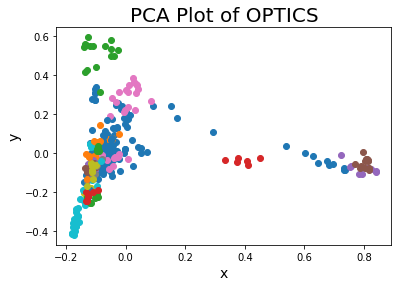

****IT_과학****
PCA OPTICS


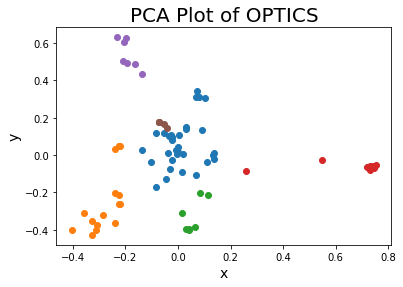

****사회****
PCA OPTICS


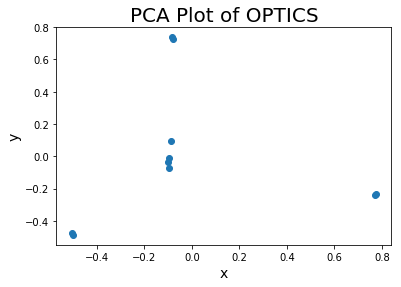

****지역****
PCA OPTICS


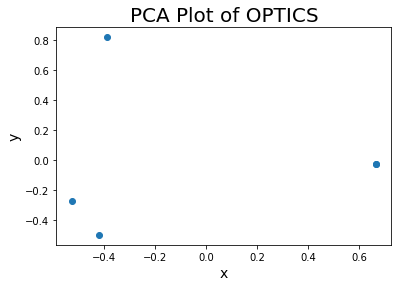

excution time : 3.754788398742676


In [0]:
tic = time.time()

topic_label_dict = {}
for category, tfidf_vec in x_cat_dict.items():
    cluster_obj = ns.Get2DPlot()
    
    print(f'****{category}****')
    
    vec_2d = cluster_obj.get_2D_vec(tfidf_vec,'tfidf','PCA')
    topic_label = cluster_obj.get_cluster_labels(True,cluster_method= 'OPTICS')
    cluster_obj.plot2D()  
    
    topic_label_dict[category] = topic_label
toc = time.time()
print(f'excution time : {toc-tic}')
time_list.append(toc-tic)

In [0]:
# 카테고리별 토픽할당
df_final = pd.DataFrame()
for cat in cat_list:
    df_tmp = df_cat_proper[df_cat_proper['cat_selected'] == cat].copy()
    df_tmp['topic'] = topic_label_dict[cat]
    df_final = pd.concat([df_final,df_tmp])

In [0]:
display(df_final)

,date,title,content,category,date_tmp,tokenized_doc,tokenized_title,cat_selected,topic
0,2019-04-19,"미래에셋대우-에트리홀딩스, 중소·벤처기업 성장지원 업무 협약",[ 이송렬 기자 ] \n \n미래에셋대우는 미래에셋센터원에서 에트리홀딩스(주)와 '...,[경제>산업_기업],737168,"[미래에셋대우, 미래에셋센터원, 에트리홀딩스, 중소, 벤처기업, 성장지원, 업무, ...","[미래에셋대우, 에트리홀딩스, 중소, 벤처기업, 성장지원, 업무, 협약]",경제,-1
1,2019-04-19,"미래에셋대우, 에트리홀딩스와 `중소·벤처기업 성장 지원` MOU 체결",미래에셋대우는 지난 18일 서울 중구 미래에셋센터원에서 에트리홀딩스와 '중소·벤처 ...,"[경제>산업_기업, 경제>취업_창업]",737168,"[미래에셋대우, 서울, 중구, 미래에셋센터원, 에트리홀딩스, 중소, 벤처, 기업, ...","[미래에셋대우, 에트리홀딩스, 중소, 벤처기업, 성장, 지원, 체결]",경제,-1
2,2019-04-19,홍콩 오피스 빌딩에 2800억 투자한 미래에셋대우,[디지털타임스 차현정 기자] 미래에셋대우는 18일 홍콩 CBD2(이스트 카우룽)에 ...,"[경제>국제경제, 경제>금융_재테크, 경제>산업_기업]",737168,"[디지털타임스, 미래에셋대우, 홍콩, 이스트, 카우룽, 위치, 오피스, 빌딩, 골딘...","[홍콩, 오피스, 빌딩, 투자, 미래에셋대우]",경제,12
3,2019-04-18,홍콩 오피스 빌딩에 2800억 투자한 미래에셋대우,[디지털타임스 차현정 기자] 미래에셋대우는 18일 홍콩 CBD2(이스트 카우룽)에 ...,"[경제>국제경제, 경제>금융_재테크, 경제>산업_기업]",737167,"[디지털타임스, 미래에셋대우, 홍콩, 이스트, 카우룽, 위치, 오피스, 빌딩, 골딘...","[홍콩, 오피스, 빌딩, 투자, 미래에셋대우]",경제,12
4,2019-04-18,해외 부동산 쓸어담는 미래에셋대우,쾰른·파리 찍고 다시 홍콩…새 업무지구 빌딩에 2800억 투자 \n \n내달 5억弗...,"[경제>금융_재테크, 경제>산업_기업, 경제>국제경제]",737167,"[쾰른, 파리, 홍콩, 새, 업무지구, 빌딩, 투자, 내달, 채권, 발행, 실탄, ...","[해외, 부동산, 어담, 미래에셋대우]",경제,12
5,2019-04-18,해외 부동산 투자 속도내는 미래에셋대우,[ 오형주/김진성 기자 ] 미래에셋대우가 올 들어 홍콩과 유럽 등 해외 부동산 투자...,"[경제>금융_재테크, 경제>산업_기업, 경제>국제경제]",737167,"[오형, 미래에셋대우, 홍콩, 유럽, 해외, 부동산, 투자, 속도, 건, 수천, 대...","[해외, 부동산, 투자, 속도, 미래에셋대우]",경제,12
6,2019-04-18,"미래에셋대우, 홍콩 랜드마크 오피스에 2800억원 투자","[머니투데이 임동욱 기자] [메자닌 대출에 2억4300만달러 투자...""짧은 만기 ...","[경제>국제경제, 경제>금융_재테크, 국제>중국]",737167,"[머니투데이, 메자닌, 대출, 억만, 투자, 만기, 수익성, 투자, 매력, 골딘, ...","[미래에셋대우, 홍콩, 랜드마크, 오피스, 투자]",경제,12
7,2019-04-18,"미래에셋대우, 홍콩 오피스 빌딩에 2800억원 투자",[디지털타임스 김민주 기자] 미래에셋대우가 홍콩 카오룽 반도에 위치한 오피스 빌딩 ...,"[국제>중국, 경제>국제경제, 경제>금융_재테크]",737167,"[디지털타임스, 미래에셋대우, 홍콩, 카오룽, 반도, 위치, 오피스, 빌딩, 골딘,...","[미래에셋대우, 홍콩, 오피스, 빌딩, 투자]",경제,12
8,2019-04-18,"미래에셋대우, 홍콩 구룡반도 오피스빌딩에 2800억원 투자",[ 한민수 기자 ] \n \n미래에셋대우는 18일 홍콩 이스트 카우룽에 위치한 오피...,"[경제>금융_재테크, 경제>국제경제]",737167,"[미래에셋대우, 홍콩, 이스트, 카우룽, 위치, 오피스, 빌딩, 골딘, 파이낸셜, ...","[미래에셋대우, 홍콩, 구룡반도, 오피스, 빌딩, 투자]",경제,12
9,2019-04-18,"미래에셋대우, 홍콩 구룡반도 오피스빌딩 2800억 투자",[디지털타임스 차현정 기자] 미래에셋대우는 18일 홍콩 CBD2(이스트 카우룽)에 ...,"[경제>국제경제, 경제>금융_재테크, 경제>산업_기업]",737167,"[디지털타임스, 미래에셋대우, 홍콩, 이스트, 카우룽, 위치, 오피스, 빌딩, 골딘...","[미래에셋대우, 홍콩, 구룡반도, 오피스, 빌딩, 투자]",경제,12


## 토픽 별 대표기사 추출

In [0]:
tic = time.time()
df_main = keyword_extractor.get_news(df_final)
toc = time.time()
print(f'excution time : {toc-tic}')
time_list.append(toc-tic)

excution time : 0.8628804683685303


In [0]:
print(df_main.shape)
display(df_main)

(31, 9)


,date,title,content,category,date_tmp,tokenized_doc,tokenized_title,cat_selected,topic
296,2018-06-10,"미래에셋대우 과천사옥, 재개발 사업 '난기류'",[머니투데이 전병윤 기자] [멀티에셋운용이 25층 오피스텔로 건축…조망권 침해 소지...,[경제>부동산],736855,"[머니투데이, 멀티, 셋, 운용, 층, 오피스텔, 건축, 망, 침해, 소지로, 민원...","[미래에셋대우, 과천, 사옥, 재개발, 사업, 난기, 류]",경제,-1
2,2019-04-19,홍콩 오피스 빌딩에 2800억 투자한 미래에셋대우,[디지털타임스 차현정 기자] 미래에셋대우는 18일 홍콩 CBD2(이스트 카우룽)에 ...,"[경제>국제경제, 경제>금융_재테크, 경제>산업_기업]",737168,"[디지털타임스, 미래에셋대우, 홍콩, 이스트, 카우룽, 위치, 오피스, 빌딩, 골딘...","[홍콩, 오피스, 빌딩, 투자, 미래에셋대우]",경제,12
12,2019-04-16,"미래에셋대우, 국내 선물·옵션 온라인 수수료 지원 이벤트","[디지털타임스 김민주 기자] 미래에셋대우는 다이렉트 비대면 국내선물, 옵션 온라인 ...","[경제>서비스_쇼핑, 경제>금융_재테크, 경제>산업_기업]",737165,"[디지털타임스, 미래에셋대우, 다이렉트, 비대면, 국내선, 물, 옵션, 온라인, 수...","[미래에셋대우, 국내, 선물, 옵션, 온라인, 수수료, 지원, 이벤트]",경제,5
20,2019-04-09,미래에셋대우 2019 제1회 전국 자산관리 세미나 개최,미래에셋대우는 10일 오후 4시부터 전국 영업점에서 자산관리세미나를 개최한다고 9일...,[경제>경제일반],737158,"[미래에셋대우, 오후, 전국, 영업점, 자산, 세미나, 개최, 세미나, 포트폴리오,...","[미래에셋대우, 전국, 자산, 세미나, 개최]",경제,19
61,2019-02-28,"미래에셋대우, 주당 220원 현금배당…""주주가치 제고""",[디지털타임스 차현정 기자] 미래에셋대우가 주당 220원의 현금배당을 실시한다. \...,"[경제>국제경제, 경제>금융_재테크, 경제>산업_기업]",737118,"[디지털타임스, 미래에셋대우, 현금, 배당, 실시, 미래에셋대우, 결산, 배당, 보...","[미래에셋대우, 현금, 배당, 주주, 가치]",경제,14
213,2018-08-30,"김대환 미래에셋대우 WM연금지원부문 대표 ""외화내빈 퇴직연금… 자동투자制로 수익률 ...",전문가가 장기간 분산투자하면 \n수익률 높고 변동성 크게 줄어 \n \n美선 자산 ...,"[경제>증권_증시, 경제>국제경제, 경제>금융_재테크]",736936,"[전문가, 장기간, 분산, 투자, 수익률, 변동성, 자산, 타깃, 데이트, 펀드, ...","[김대환, 미래에셋대우, 연금, 지원, 대표, 외화, 내빈, 퇴직, 연금, 자동, ...",경제,1
90,2019-01-18,"미래에셋대우, 홍콩법인에 5000억원 출자",영국법인 주식 3360억 처분 \n \n \n[ 오형주 기자 ] 미래에셋대우가 브렉...,"[국제>유럽_EU, 경제>국제경제, 경제>산업_기업]",737077,"[영국, 법인, 주식, 처분, 미래에셋대우, 브렉, 시트, 영국, 유럽연합, 탈퇴,...","[미래에셋대우, 홍콩, 법인, 출자]",경제,8
96,2019-01-14,"미래에셋대우, 달러 청약 ELS 등 투자상품 9종 판매",미래에셋대우는 달러 청약 ELS를 비롯한 9종의 상품을 약 1250억원 규모로 판매...,"[경제>금융_재테크, 경제>국제경제, 경제>증권_증시]",737073,"[미래에셋대우, 청약, 비롯, 종, 상품, 규모, 판매, 판, 매하, 청약, 스텝,...","[미래에셋대우, 청약, 투자, 상품, 종, 판매]",경제,3
98,2019-01-09,"[포토] 미래에셋대우, 코람코자산신탁과 리츠투자 활성화를 위한 전략적 MOU 체결",미래에셋대우는 지난 8일 포시즌스 호텔에서 코람코자산신탁과 '리츠투자 활성화를 위한...,"[경제>산업_기업, 경제>취업_창업, 경제>금융_재테크]",737068,"[미래에셋대우, 포시즌스, 호텔, 코람코, 자산, 신탁, 리츠, 투자, 활성화, 업...","[포토, 미래에셋대우, 코람코, 자산, 신탁, 리츠, 투자, 활성화, 전략, 체결]",경제,20
127,2018-12-26,"미래에셋대우, 아마존 신설 물류센터 인수 작업 완료",미래에셋대우는 세계 최대 전자상거래기업 아마존의 신설 물류센터 인수를7800만달러(...,"[경제>산업_기업, 경제>국제경제]",737054,"[미래에셋대우, 세계, 전자상거래, 기업, 아마존, 신설, 물류, 센터, 만달, 인...","[미래에셋대우, 아마존, 신설, 물류, 센터, 작업, 완료]",경제,17


In [0]:
eco_news = df_final[df_final['cat_selected']=='경제'].copy()
topics = eco_news['topic'].unique().tolist()
for topic in topics:
    print(f'=====topic {topic}=====')
    tmp = eco_news[eco_news['topic']==topic].copy()
    display(tmp['title'])

=====topic -1=====


0                      미래에셋대우-에트리홀딩스, 중소·벤처기업 성장지원 업무 협약
1                 미래에셋대우, 에트리홀딩스와 `중소·벤처기업 성장 지원` MOU 체결
10                          "미래에셋대우, 올해 실적 개선 기대…목표가 하향"
11                              미래에셋대우, '생명' 주식 매일 담는 까닭
15            홍성국 전 미래에셋대우 사장 "벤처기업 육성 절박함이 '수축사회' 막을 것"
16                             미래에셋대우, ELW 수수료 면제 이벤트 나서
17                              미래에셋대우, ELW 매매수수료 면제 이벤트
18                             미래에셋대우, ELW 무료 수수료 이벤트 실시
19                              미래에셋대우, ELW 무료 수수료 행사 실시
22                           "현대제철, 강판 가격 상승 기대"<미래에셋대우>
23                           미래에셋대우, 4월은 영업점 '통합 대형화'의 달
24                       제주항공, 1Q 예상치 넘는 호실적…목표가↑-미래에셋대우
25                          리프트 안착, 미래에셋대우 프리IPO 대박 기대감↑
26                  `자산관리 강자` 미래에셋대우, 수수료 수익 1730억 1위 수성
27                  `자산관리 강자` 미래에셋대우, 수수료 수익 1730억 1위 수성
28     [대한민국 100대 CEO] 최현만 미래에셋대우 수석부회장 | 자기자본 1위 국내 ...
29                 미래에셋대우, `자산관리 강자` 자리매김…수수료 수익 1위 `수성`
30                  미래에셋대우 온라인전

=====topic 12=====


2         홍콩 오피스 빌딩에 2800억 투자한 미래에셋대우
3         홍콩 오피스 빌딩에 2800억 투자한 미래에셋대우
4                  해외 부동산 쓸어담는 미래에셋대우
5               해외 부동산 투자 속도내는 미래에셋대우
6      미래에셋대우, 홍콩 랜드마크 오피스에 2800억원 투자
7        미래에셋대우, 홍콩 오피스 빌딩에 2800억원 투자
8    미래에셋대우, 홍콩 구룡반도 오피스빌딩에 2800억원 투자
9      미래에셋대우, 홍콩 구룡반도 오피스빌딩 2800억 투자
Name: title, dtype: object

=====topic 5=====


12               미래에셋대우, 국내 선물·옵션 온라인 수수료 지원 이벤트
13                미래에셋대우, 비대면 국내선물·옵션 온라인 수수료 지원
53            미래에셋대우, 비대면 계좌 계설 및 타사주식 입고 이벤트 나서
79     미래에셋대우, 연 3.9%로 투자금 빌려주는 `다이렉트 융자` 이벤트 나서
80            미래에셋대우, 다이렉트 신용·담보 융자 연 3.9% 행사 실시
105      미래에셋대우, 신규·휴면 계좌 대상 `트리플 혜택 BIG 이벤트` 나서
160         미래에셋대우, 주식거래 고객 대상 총 2억5000만원 경품 이벤트
161              미래에셋대우, 고객 감사 이벤트…총 2억5000만원 경품
237                    미래에셋대우, 다이렉트 타사 주식 입고 이벤트
238         미래에셋대우, 비대면 계좌로 주식 입고 후 거래시 최대 100만원
294                미래에셋대우, 8월 말까지 해외선물·옵션 이벤트 실시
305          미래에셋대우, 국내주식 고객 대상 '슈퍼 페스티벌 2회차' 진행
306                   미래에셋대우, "주식 거래하고 경품 응모하세요"
355                    미래에셋대우, 다이렉트 비대면 계좌개설 이벤트
366                  미래에셋대우, "주식 거래하면 풍성한 경품 지급"
367                     미래에셋대우, 국내주식 거래고객 추첨 이벤트
404                    미래에셋대우, 해외주식투자자 대상 이벤트 실시
439            미래에셋대우, 해외선물·옵션 온라인 수수료 2.18弗 이벤트
Name: title, dtype: object

=====topic 19=====


20                     미래에셋대우 2019 제1회 전국 자산관리 세미나 개최
21                 미래에셋대우, 9일 `핵심자산` 주제로 전국자산관리세미나 개최
142                      미래에셋대우의 제4회 AI Club 투자세미나 성료
178                      미래에셋대우, 24일 전국 동시 자산관리세미나 개최
199    미래에셋대우, 제3회 Accredited Investors Club 투자세미나 성료
248                     미래에셋대우 "전문투자자 서비스 확대…전담인력 양성"
Name: title, dtype: object

=====topic 14=====


61            미래에셋대우, 주당 220원 현금배당…"주주가치 제고"
62           미래에셋대우, 주당 220원 현금배당...배당성향 34%
63               미래에셋대우, 보통주 1주당 220원 현금배당키로
312    미래에셋대우, 3년간 배당성향 25% 유지…주주친화 노력 확인-한투
313                 미래에셋대우, 3년간 배당 25% 이상 유지
314              미래에셋대우 "3년간 배당성향 최소 25% 유지"
315              미래에셋대우, 3년간 최소 25% 배당 성향 유지
316                미래에셋대우, "3년간 배당성향 25% 이상"
317               미래에셋대우 "3년간 배당성향 25% 보장한다"
318             미래에셋대우, "3년간 배당성향 최소 25% 보장"
319              미래에셋대우 "3년간 배당성향 최소 25% 유지"
321              미래에셋대우 "3년간 배당성향 최소 25% 보장"
Name: title, dtype: object

=====topic 1=====


83                              미래에셋대우, '연금 프러포즈 이벤트' 실시
84                 미래에셋대우, 개인형연금 신규 가입자 대상 `프러포즈 이벤트` 나서
167                             미래에셋대우, 연금저축계좌 만들면 상품 지급
213    김대환 미래에셋대우 WM연금지원부문 대표 "외화내빈 퇴직연금… 자동투자制로 수익률 ...
224                           미래에셋대우, 업계 최초 연금자산 11조원 돌파
225                          미래에셋대우, 증권업 최초 연금자산 11조원 돌파
226                            미래에셋대우 연금자산, 업계 첫 11조원 돌파
244                      미래에셋대우, 전국민 개방형 연금자산관리센터 개점 이벤트
245                미래에셋대우, '전 국민 개방형 연금자산관리센터' 오픈 이벤트 실시
277                                      미래에셋대우 연금자산관리센터
278                             미래에셋대우, 개방형 연금자산관리센터 문열어
279                   미래에셋대우, 누구나 이용 가능한 개방형 연금자산관리센터 출범
280                  미래에셋대우, 개방형 연금자산관리센터 출범…"누구나 이용 가능"
281                       미래에셋대우, "개방형 연금자산관리센터, 전국민 이용"
363                                  미래에셋대우, 연금 비즈니스의 강자
438                        미래에셋대우, '노후계획, 연금이 좋다' 이벤트 실시
Name: title, dtype: object

=====topic 8=====


90                        미래에셋대우, 홍콩법인에 5000억원 출자
92                          미래에셋대우, 런던서 돈빼 홍콩 보낸다
189            [단독] 증권사 해외 수익 늘었지만…미래에셋대우가 75% 차지
215                         미래에셋대우 박현주號 해외사업 `순항`
216                         미래에셋대우 박현주號 해외사업 `순항`
217    미래에셋대우, `박현주호` 해외사업 순항…상반기 해외법인 당기순익 230%↑
236                            미래에셋대우, `글로벌IB` 간다
239         미래에셋대우 해외에 14개 거점…방대한 네트워크로 글로벌 IB 박차
240                            미래에셋대우, `글로벌IB` 간다
303     미래에셋대우 회장 물러난 박현주…국내 전문경영인시대 열고 해외사업 전력투구
328                     박현주 미래에셋대우 회장, ‘경영 2선’ 왜?
334                박현주, 미래에셋대우 글로벌 경영에 주력…회장서 물러나
335                박현주 미래에셋대우 회장, 회장직 물러나 해외사업 주력
336                   박현주 미래에셋대우 회장, 글로벌경영전략고문 선임
337                박현주, 미래에셋대우 회장 물러나 "글로벌 경영 집중"
338            박현주 회장, 미래에셋대우 글로벌 경영에 주력…GISO로 선임
339            박현주 회장, "미래에셋대우 GISO 맡고 글로벌 경영 주력"
340           박현주, 미래에셋대우 회장 물러나...글로벌 전략에 집중(종합)
419                  미래에셋대우, 미국 내 지주사 설립…3007억 출자
420                    [인사] 박현주 미래에셋대우 홍콩법인 회장 취임


=====topic 3=====


96           미래에셋대우, 달러 청약 ELS 등 투자상품 9종 판매
179                    미래에셋대우, 주가연계증권 9종 판매
208     미래에셋대우, 손실 나면 해외주식 지급 ELS 포함 12종 판매
209                   미래에셋대우, 주가연계증권 12종 판매
293                   미래에셋대우, 주가연계증권 11종 판매
320                    미래에셋대우, 주가연계증권 9종 판매
331                    미래에셋대우, 주가연계증권 8종 판매
365                    미래에셋대우, 주가연계증권 7종 판매
405                    미래에셋대우, 주가연계증권 9종 판매
435    미래에셋대우, "만기 손실시 현금대신 해외주식 지급" ELS 판매
436                  미래에셋대우, 주가연계증권 등 9종 판매
Name: title, dtype: object

=====topic 20=====


98     [포토] 미래에셋대우, 코람코자산신탁과 리츠투자 활성화를 위한 전략적 MOU 체결
100                   미래에셋대우·코람코자산신탁, 리츠투자 활성화 위해 맞손
101                   미래에셋대우, 코람코자산신탁과 리츠 활성화 MOU 체결
102                    미래에셋대우, 코람코자산신탁과 리츠투자 활성화 MOU
144                  미래에셋대우 조직개편…총괄직 신설 및 IB·트레이딩 강화
145                            미래에셋대우, IB·트레이딩 조직 강화
146                미래에셋대우, 조직개편…IB·트레이딩 리스크 관리 강화 중점
Name: title, dtype: object

=====topic 17=====


116              미래에셋대우, 아마존 물류센터 878억에 인수
117    대체투자 늘리는 미래에셋대우, 아마존 물류센터에 880억원 투자
118              미래에셋대우, 아마존 물류센터 878억에 인수
119          미래에셋대우, 아마존 신설 물류센터 900억원에 인수
120                  미래에셋대우, 美 아마존 물류센터 인수
121                  미래에셋대우, 美아마존 물류센터 품었다
124             미래에셋대우, 아마존 물류센터 878억원에 인수
125        미래에셋대우, 아마존 신설 물류센터 7800만달러에 인수
126        미래에셋대우, 美 애틀란타 '아마존' 신설 물류센터 인수
127           미래에셋대우, 아마존 신설 물류센터 인수 작업 완료
Name: title, dtype: object

=====topic 0=====


129           저축은행연합회·미래에셋대우… 저축은행 정기예금 업무 협약
130    미래에셋대우-저축은행중앙회, 랩어카운트내 저축은행 예금 편입 업무협약
131            미래에셋대우, 랩어카운트에 저축은행 정기예금 편입 추진
132         미래에셋대우, 증권사 최초 '랩어카운트'에 저축銀 예금 편입
133     미래에셋대우, 랩어카운트에 저축은행 정기예금 편입 위한 MOU 체결
Name: title, dtype: object

=====topic 4=====


134    미래에셋대우, 양방향 수익 추구·손실시 실물 지급 등 ELS 8종 모집
135                 미래에셋대우, 양방향 수익 추구 ELS 등 판매
139      미래에셋대우, 손실 발생 구간서 기초자산 실물 주는 ELS 판매 중
140              미래에셋대우, 손실시 해외주식 실물 지급 ELS 판매
149                       미래에셋대우, 주가연계증권 6종 판매
211          미래에셋대우, 손실 나면 해외주식 실물 지급 ELS 등 판매
218                    미래에셋대우, 주가연계증권 총 10종 판매
219              미래에셋대우, 손실나면 해외주식 지급 ELS 등 판매
242                          미래에셋대우, ELS 7종 판매
247          미래에셋대우, 손실나면 해외주식 지급 ELS 포함 7종 판매
262                미래에셋대우, 손실나면 해외주식 주는 ELS 판매
263                      미래에셋대우, 주가연계증권 11종 판매
Name: title, dtype: object

=====topic 16=====


143    [금융 특집] 미래에셋대우증권, 10개국에 인재 보내…2년간 글로벌 전문가 200명 육성
250                     미래에셋대우, 프로그램 도입… 글로벌 금융투자 전문가 양성
251                   "글로벌 인재 키운다"… 미래에셋대우, 매년 50여명 해외연수
253                  미래에셋대우, "사내 해외연수 프로그램 도입…글로벌 인재 육성"
254                    미래에셋대우, 해외 연수프로그램 도입…글로벌 인재 육성 박차
Name: title, dtype: object

=====topic 18=====


174                    미래에셋대우, 사회적책임委 설치
175                  미래에셋대우, 사회적책임위원회 설치
176         미래에셋대우, 사회공헌강화위해 사회적책임위원회 출범
177    미래에셋대우, 소비자보호·사회공헌 강화 '사회적책임委' 출범
201            미래에셋대우, 7년 연속 DJSI월드지수 선정
Name: title, dtype: object

=====topic 10=====


190     미래에셋대우·KB증권, 호반건설 상장 대표주관사 선정
191    미래에셋대우-KB증권, 호반그룹 상장 대표주관사로 선정
192     미래에셋대우-KB증권, 호반그룹 상장 대표주관사 선정
444         호반건설, 미래에셋대우 우선주에 500억 투자
445         호반건설, 미래에셋대우 우선주에 500억 투자
446        미래에셋대우 유상증자 호반건설, 500억원 참여
Name: title, dtype: object

=====topic 2=====


193    미래에셋대우, 해외주식 지급형 글로벌 ELS 만기 상환…수익률 15.63%
194     미래에셋대우, 업계 첫 '해외주식지급형 ELS' 수익률 15.6%로 상환
195               미래에셋대우, 해외주식 지급형 글로벌 ELS 만기 상환
431        미래에셋대우 "업계 최초 출시 해외주식지급형 ELS 100억 완판"
432       미래에셋대우, 업계 첫 '해외주식지급형 글로벌 ELS' 100억 완판
433             미래에셋대우, 해외주식지급형 글로벌 ELS 100억원 완판
Name: title, dtype: object

=====topic 7=====


229                           미래에셋대우 상반기 최대 실적
230          미래에셋대우, 2Q 영업익 21.8%↑…반기 최대 실적 달성
231       미래에셋대우, 상반기 영업익 4276억·순익 3578억…사상 최대
232      미래에셋대우, 올 상반기 영업이익 4276억원…사상 최대 실적 경신
233         미래에셋대우 상반기 영업익 4276억…"사상 최대 반기 실적"
234           미래에셋대우, 2분기 순이익 1571억원…전년比 4.0%↓
235    미래에셋대우, 상반기 영업익 4276억원...연 1兆 목표까지 '성큼'
Name: title, dtype: object

=====topic 21=====


323                   미래에셋대우, 올해 300명 채용
324    미래에셋대우, 올해 300명 채용…"연말엔 4900명 육박"
325              미래에셋대우, 올 하반기 150명 채용한다
326               미래에셋대우, 하반기 150명 채용 예정
327                  미래에셋대우, 올해 300명 뽑는다
Name: title, dtype: object

=====topic 6=====


347              미래에셋대우 11년 만에 ‘분기 순익 2000억원’ 돌파
348            미래에셋대우, 1Q 영업익 2146억...전년비 49.6%↑
349            미래에셋대우, 1분기 순이익 2007억원…전년比 82.2%↑
350    미래에셋대우, 1Q 영업익 2146억 전년比 50%↑ "전부문 고른 성장"
351    미래에셋대우, 1분기 세전익 2162억…"2분기 이후 자본확충 효과 기대"
Name: title, dtype: object

=====topic 11=====


368                5조원대 홍콩빌딩 인수에 미래에셋대우 3200억 투자
369                        미래에셋대우, 홍콩 빌딩에 3억弗 투자
370                미래에셋대우, 홍콩 최고 몸값 `더센터` 3억弗 베팅
371    미래에셋대우, 리카싱 소유 홍콩 더센터 빌딩 인수 참여…3억불 투자(상보)
372                 미래에셋대우, '더센터' 빌딩 인수에 3억달러 투자
373        미래에셋대우, 리카싱 소유 홍콩 더센터 빌딩 인수 참여…3억불 투자
374          미래에셋대우, 5.5조원 규모 홍콩 '더센터' 빌딩 인수전 참여
375                       미래에셋대우, 홍콩 `더센터` 빌딩 인수
Name: title, dtype: object

=====topic 13=====


383    [Hot-Line] "미래에셋대우, 자사주 소각 결정 긍정적…중장기적 관심"
385                     미래에셋대우, 자사주 800만주 매입 후 소각
386                       미래에셋대우, 자사주 800만株 매입·소각
387                     미래에셋대우, 자사주 800만주 취득 후 소각
388                       미래에셋대우, 자사주 800만주 매입 소각
389          미래에셋대우, 통큰 주주환원…자사주 800만주 매입 후 소각 결정
390                 미래에셋대우, 보통주 자사주 800만주 취득 후 소각
391                     미래에셋대우, 자사주 800만주 취득 및 소각
Name: title, dtype: object

=====topic 9=====


447    [경제 브리핑] 미래에셋대우 뭄바이 법인 세우고 인도 진출
448           `공격 투자` 미래에셋대우, 글로벌 IB 성큼
449      미래에셋대우, 인도현지법인 개업 "인도시장 본격 공략"
450               미래에셋대우, 인도 현지법인 영업 시동
451               미래에셋대우, 인도 현지법인 영업 시작
452            미래에셋대우, 인도 뭄바이서 현지법인 개업식
453             미래에셋대우, 인도 현지법인 증권영업 개시
Name: title, dtype: object

=====topic 15=====


454    미래에셋대우, 7000억 유상증자 마무리…자기자본 8조 달성
455                  미래에셋대우 유상증자 청약률 90%
456    미래에셋대우, 7000억원 유상증자 마무리…자본 8조원 확보
458      미래에셋대우, 7000억 유증 마무리…자기자본 8조 달성
461     미래에셋대우, 유증 청약률 65.6%…4812만주 일반공모
462      미래에셋대우 4800만주 일반공모…26일부터 이틀간 진행
463          미래에셋캐피탈, 미래에셋대우 유증에 300억 출자
466         미래에셋대우 임직원 90%, 우리사주 유상증자 참여
468                미래에셋대우 우리사주, 이번에도 대박?
Name: title, dtype: object

In [0]:
# 저장
with open('tokenized data/df_final.pickle','wb') as handle:
    pickle.dump(df_final,handle,protocol=pickle.HIGHEST_PROTOCOL)   
with open('tokenized data/df_main.pickle','wb') as handle:
    pickle.dump(df_main,handle,protocol=pickle.HIGHEST_PROTOCOL)    

## 카테고리 - 토픽 / 시간에 따른 뉴스 빈도

In [0]:
# 카테고리 별 토픽 수 
df_final.groupby(['cat_selected'])['topic'].nunique()

cat_selected
IT_과학     6
경제       23
사회        1
지역        1
Name: topic, dtype: int64

In [0]:
# 카테고리 - 토픽 별 기사 수
df_final.groupby(['cat_selected','topic'])['title'].count()

cat_selected  topic
IT_과학         -1        32
               0        16
               1         7
               2         8
               3         7
               4         5
경제            -1       177
               0         5
               1        16
               2         6
               3        11
               4        12
               5        18
               6         5
               7         7
               8        25
               9         7
               10        6
               11        8
               12        8
               13        8
               14       12
               15        9
               16        5
               17       10
               18        5
               19        6
               20        7
               21        5
사회            -1        10
지역            -1         5
Name: title, dtype: int64

## 단계별 처리 시간 시각화

* DB SCAN
    * excution time : 0.7, 
    * total : 2.53
* OPTICS  
    * excution time : 3.5
    * total : 5.6

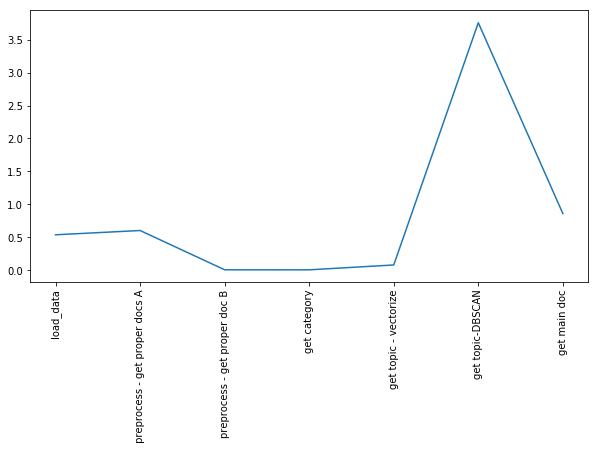

total excution time : 5.865755081176758


In [0]:
plt.figure(figsize = (10,5))
plt.plot(time_list)
plt.xticks(ticks = list(range(7)),labels = process, rotation = 'vertical')
plt.show()
print(f'total excution time : {np.sum(time_list)}')